In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import scipy.signal as ss
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from simulate_triple import simulate
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from tools_plot import despine, set_style, regplot
import pandas as pd
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
import pathlib
from causal_optoconnectics.core import find_response_spikes
from causal_optoconnectics.buzsaki import transfer_probability

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

In [4]:
colors = ['#1b9e77', '#d95f02', '#7570b3']

In [5]:
# base_path = pathlib.Path('/home/mikkel/data/data_branched_stim_idstsswitched')
base_path = pathlib.Path('/home/mikkel/data/data_intermed/')

In [6]:
connections = np.load(base_path / 'm.npz', allow_pickle=True)['m'][()]

In [7]:
N = connections.shape[0]

In [8]:
df = pd.DataFrame([
    (j, i, connections[i, j]) for i in range(N) for j in range(N) if i!=j],
    columns=['source', 'target', 'weight']
)

In [9]:
paths = [path for path in base_path.iterdir() if path.is_dir()]
paths = sorted(paths, key=lambda x: int(x.stem))

In [10]:
stim_times = []
trials_t = []
trials_i = []
spikes = np.array([])
spike_ids = np.array([])
start_after = [0]
for i, path in enumerate(paths):
    print('Loading', path)
    try:
        spks = np.load(path / 'spks1.npz', allow_pickle=True)['data'][()]
    except:
        print('Failed to load', path)
        start_after.append(start_after[i])
        continue
#     spikes = np.concatenate([spikes, np.array(spks['spk_ids']) + start_after[i]])
#     spike_ids = np.concatenate([spike_ids, np.array(spks['spk_ts'])])
    spikes = np.concatenate([spikes, np.array(spks['spk_ts']) + start_after[i]])
    spike_ids = np.concatenate([spike_ids, np.array(spks['spk_ids'])])
    
    stim_times_c = []
    trials_t_c = []
    trials_i_c = []
    for fname in path.glob('stimulation_data*.npz'):
        data = np.load(fname, allow_pickle=True)['data'][()]
        stim_time = data['t'] + 2
        stim_times_c.append(stim_time + start_after[i])
        trials_t_c.append(data['spk_ts'] - stim_time)
        trials_i_c.append(data['spk_ids'])
        
    sort_idxs = np.argsort(stim_times_c)
    stim_times.extend([stim_times_c[ii] for ii in sort_idxs])
    trials_t.extend([trials_t_c[ii] for ii in sort_idxs])
    trials_i.extend([trials_i_c[ii] for ii in sort_idxs])
    
    start_after.append(start_after[i] + spks['t'] + 10)

Loading /home/mikkel/data/data_intermed/0
Loading /home/mikkel/data/data_intermed/1
Loading /home/mikkel/data/data_intermed/2
Loading /home/mikkel/data/data_intermed/3
Loading /home/mikkel/data/data_intermed/4
Loading /home/mikkel/data/data_intermed/5
Loading /home/mikkel/data/data_intermed/6
Loading /home/mikkel/data/data_intermed/7
Loading /home/mikkel/data/data_intermed/8
Loading /home/mikkel/data/data_intermed/9
Loading /home/mikkel/data/data_intermed/10
Loading /home/mikkel/data/data_intermed/11
Loading /home/mikkel/data/data_intermed/12
Loading /home/mikkel/data/data_intermed/13
Loading /home/mikkel/data/data_intermed/14
Loading /home/mikkel/data/data_intermed/15
Loading /home/mikkel/data/data_intermed/16
Loading /home/mikkel/data/data_intermed/17
Failed to load /home/mikkel/data/data_intermed/17
Loading /home/mikkel/data/data_intermed/18
Loading /home/mikkel/data/data_intermed/19


In [11]:
stim_times = np.array(stim_times)
trials_t = np.array(trials_t)
trials_i = np.array(trials_i)
spike_ids = spike_ids.astype(int)

In [12]:
test_trials = []
for tt, ii in zip(trials_t, trials_i):
    test_trials.append(tt[ii==200])

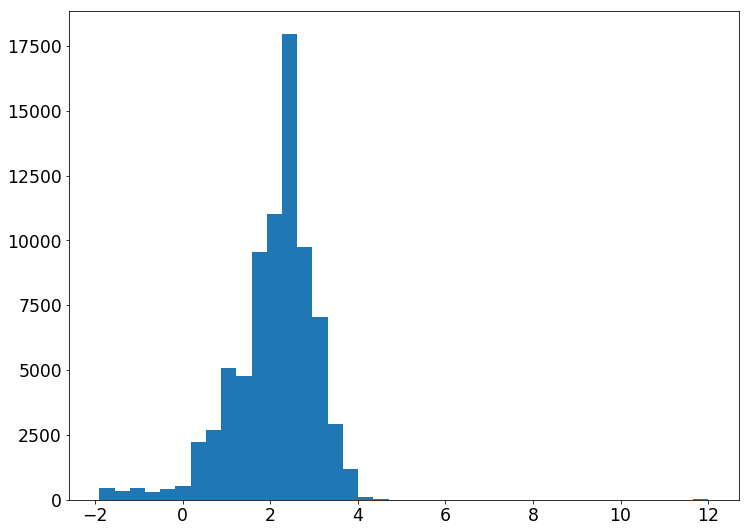

In [13]:
plt.hist([t for trial in test_trials for t in trial], bins=40);

In [14]:
z1 = 2
z2 = 0

x1 = 0
x2 = 2

y1 = 2
y2 = 4

In [15]:

Z = np.zeros((len(stim_times), N))
X = np.zeros((len(stim_times), N))
Y = np.zeros((len(stim_times), N))
for i, t in enumerate(stim_times):
    idx = np.searchsorted(spikes, [t - z1, t - z2], side='right')
    id_spiked = np.unique(spike_ids[idx[0]: idx[1]])
    Z[i,id_spiked] = 1
    
    ids_response = trials_i[i]
    ts_response = trials_t[i]
    idx = np.searchsorted(ts_response, [x1, x2], side='right')
    id_spiked = np.unique(ids_response[idx[0]: idx[1]])
    X[i,id_spiked] = 1
    
    idx = np.searchsorted(ts_response, [y1, y2], side='right')
    id_spiked = np.unique(ids_response[idx[0]: idx[1]])
    Y[i,id_spiked] = 1

In [16]:
X.shape

(98121, 4000)

In [22]:
X.shape

(80994, 4000)

In [17]:
np.where(Z==1, X, X*0).sum(0)

array([225., 258., 222., ..., 211., 227., 230.])

In [18]:
Z.sum(0)

array([2023., 2037., 1866., ..., 1913., 1924., 1962.])

In [111]:
# query = 'source > 500 and source < 900 and weight > 0 and target > 1000 and target < 3200'
# query = 'source < 1000 and weight > 0 and target >= 1000 and target < 3200'
query = 'source < 1000 and target >= 1000 and target < 3200'
sample = df.query(query)

In [112]:
sample['wr'] = sample.weight.round(3)
sample = sample.drop_duplicates('wr')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [113]:
sample = sample.sample(2000)

In [114]:
sample.shape

(2000, 4)

# look at one

In [97]:
sample = sample.sort_values('weight', ascending=False)
sample.head()

,source,target,weight,wr
12245749,811,3062,4.233131,4.233
5462742,108,1366,4.052753,4.053
9166649,941,2292,3.977784,3.978
8502581,707,2126,3.832145,3.832
11310169,997,2828,3.664579,3.665


In [98]:
source, target = sample.iloc[0][['source', 'target']].astype(int)
source, target

(811, 3062)

In [99]:
source_trials = []
for tt, ii in zip(trials_t, trials_i):
    source_trials.append(tt[ii==source])
source_trials = np.array(source_trials)
    
target_trials = []
for tt, ii in zip(trials_t, trials_i):
    target_trials.append(tt[ii==target])
target_trials = np.array(target_trials)

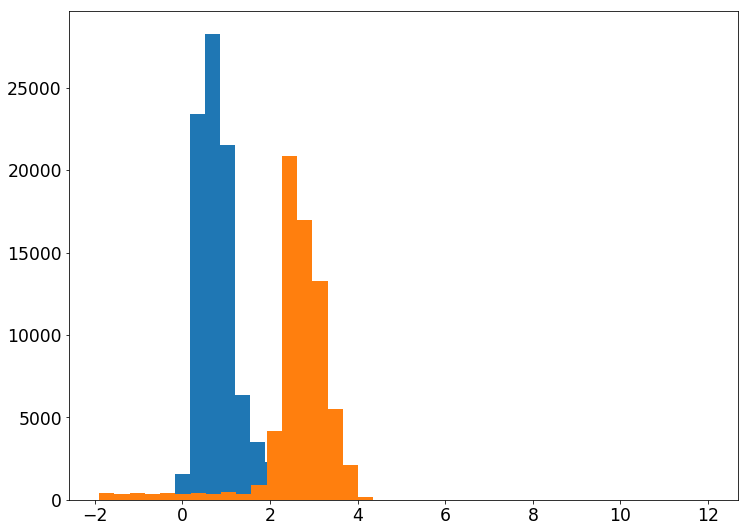

In [75]:
plt.hist([t for trial in source_trials for t in trial], bins=40);
plt.hist([t for trial in target_trials for t in trial], bins=40);

In [76]:
source_X = X[:, source]
source_Z = Z[:, source]
target_Y = Y[:, target]

In [77]:
bins = np.arange(40)

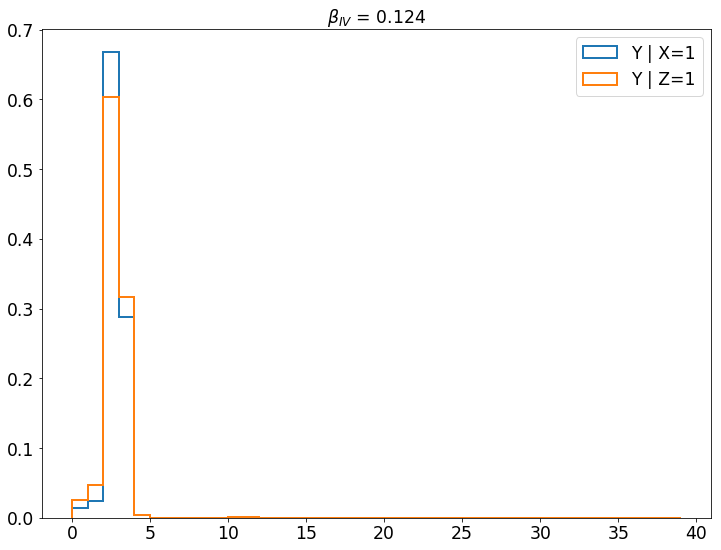

In [78]:
plt.hist([t for trial in target_trials[source_X==1] for t in trial], 
         bins=bins, histtype='step', lw=2, label='Y | X=1', density=True);

plt.hist([t for trial in target_trials[source_Z==1] for t in trial], 
         bins=bins, histtype='step', lw=2, label='Y | Z=1', density=True);
beta_iv = target_Y[source_X==1].mean() - target_Y[source_Z==1].mean()
plt.title('$\\beta_{{IV}}$ = {:.3f}'.format(beta_iv))
plt.legend()

# look at all

In [137]:
def process(row):
    z = Z[:,int(row.source)]
    x = X[:,int(row.source)]
    y = Y[:,int(row.target)]
    beta_iv = y[x==1].mean() - y[z==1].mean()
#     wald = (y[z==1].mean() - y[z==0].mean()) / (x[z==1].mean() - x[z==0].mean())
#     beta = y[x==1].mean() - y[x==0].mean()
    beta = y[x==1].mean() - np.random.choice(y[x==0], int(sum(z))).mean()
    print(
        len(y[z==1]), y[z==1].mean(), 
        len(np.random.choice(y[x==0], int(sum(z)))), np.random.choice(y[x==0], int(sum(z))).mean())
#     return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean(), 'wald': wald})
    return pd.Series({'beta_iv': beta_iv, 'beta': beta, 'hit_rate': x.mean()})

In [185]:
process(sample.iloc[0,:])

1945 0.3856041131105398 1945 0.4884318766066838


beta        0.098310
beta_iv     0.184171
hit_rate    0.545908
dtype: float64

In [131]:
result = sample.join(sample.progress_apply(process, axis=1, result_type="expand"))

HBox(children=(IntProgress(value=0, max=2000), HTML(value='')))

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}_{IV}$')

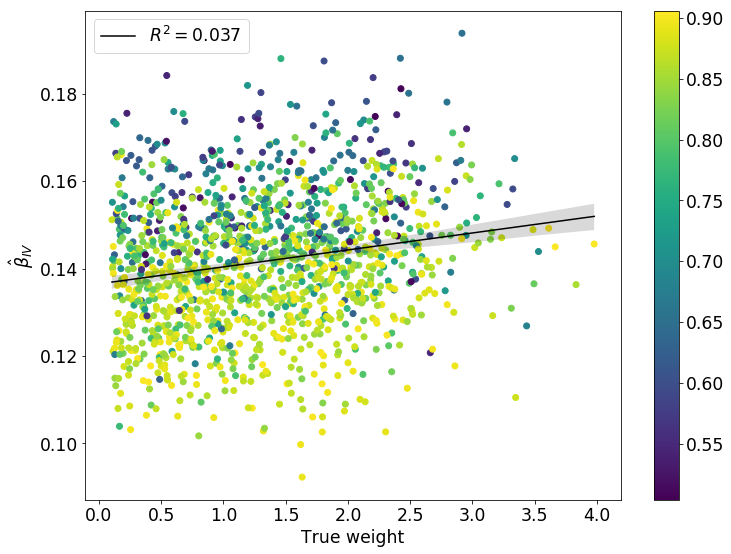

In [135]:
df_ = result.query('hit_rate > .5')
model = regplot(
    'weight', 'beta_iv', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}_{IV}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

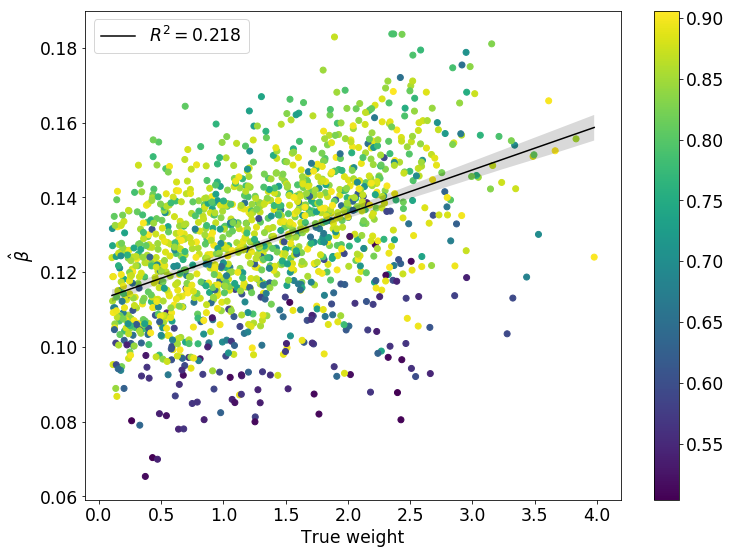

In [187]:
df_ = result.query('hit_rate > .5')
model = regplot(
    'weight', 'beta', data=df_, 
    scatter_color=df_['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('True weight')
plt.ylabel(r'$\hat{\beta}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

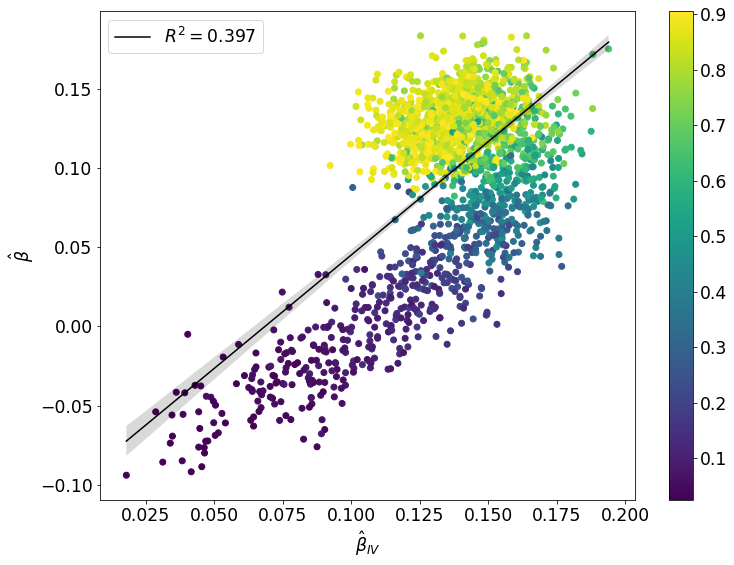

In [188]:
model = regplot(
    'beta_iv', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'$\hat{\beta}_{IV}$')
plt.ylabel(r'$\hat{\beta}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'True weight')

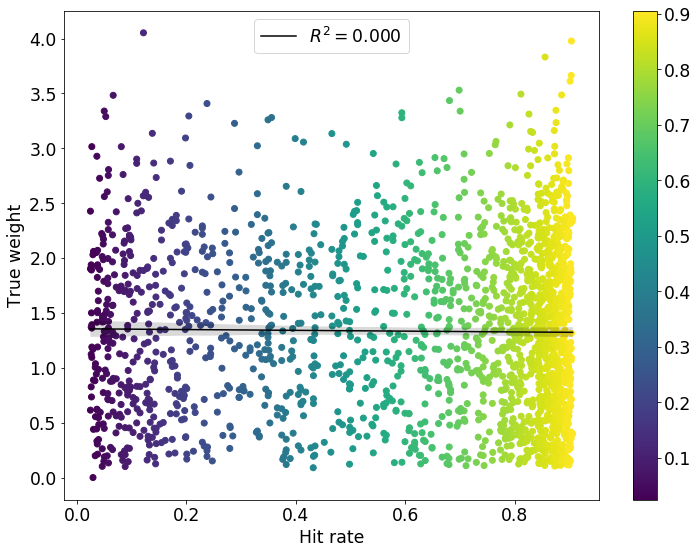

In [189]:
model = regplot(
    'hit_rate', 'weight', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel('Hit rate')
plt.ylabel('True weight')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}_{IV}$')

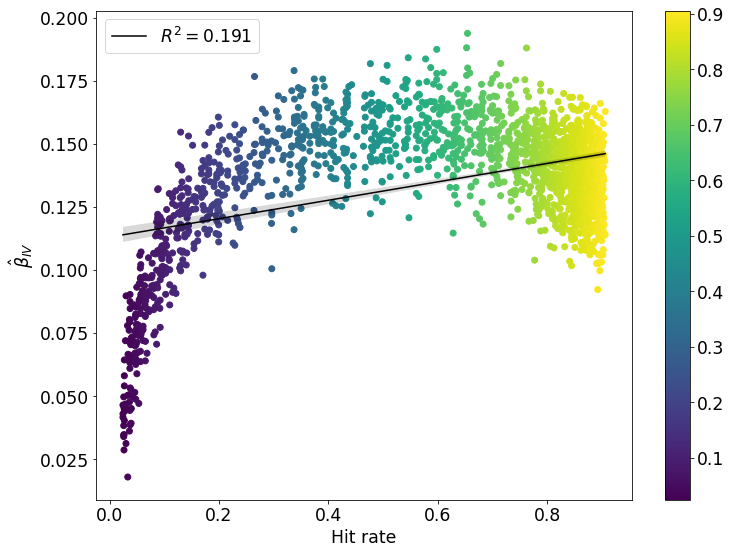

In [192]:
model = regplot(
    'hit_rate', 'beta_iv', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}_{IV}$')

/home/mikkel/.virtualenvs/main/lib/python3.5/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0,0.5,'$\\hat{\\beta}$')

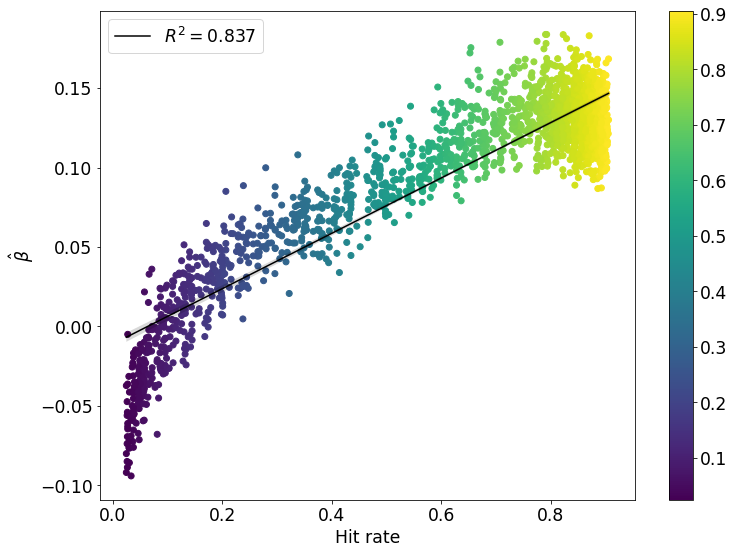

In [191]:
model = regplot(
    'hit_rate', 'beta', data=result, 
    scatter_color=result['hit_rate'], colorbar=True)

h = plt.Line2D([], [], label='$R^2 = {:.3f}$'.format(model.rsquared), ls='-', color='k')
plt.gca().legend(handles=[h])

plt.xlabel(r'Hit rate')
plt.ylabel(r'$\hat{\beta}$')

In [102]:
bins = np.arange(0, stim_times.max(), 1)
hist, bins = np.histogram(stim_times, bins=bins)

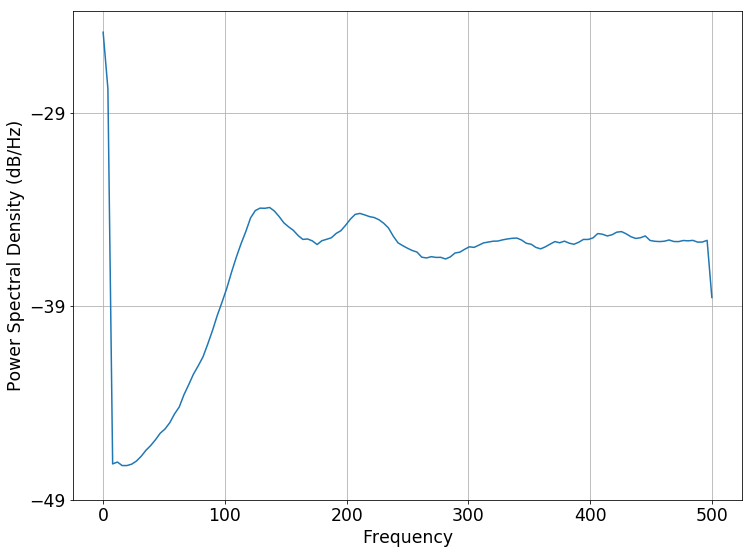

In [106]:
plt.psd(hist, Fs=1000);